# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date: ", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version: " + pyleecan.__version__)
import SciDataTool
print("SciDataTool version: " + SciDataTool.__version__)

Running date:  July 01, 2022
Pyleecan version: 1.4.0
SciDataTool version: 2.4.9


# How to use MeshSolution objects
The MeshSolution module is the part of the code which allows to store, perform operation(s), and display data linked to a mesh. For example, the magnetostatic solution from FEMM is stored using this module.

This tutorial shows the different possibilities allowed by the current features of the MeshSolution module. At the moment, it is mainly dedicated to store 2D electromagnetic fields computed with FEMM, but the goal is to generalize to any physics that could be included inside Pyleecan.
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_MeshSolution.ipynb).

This tutorial is for people who wish to understand in depth how this module works, and potentially contribute to the development of the code.

## Architecture
The main class is the MeshSolution. It has two important attributes:
- A list of instances of Mesh class. The Mesh class allows to store the parameters of the mesh (coordinates, connectivity ...).
- A list of instances of Solution class. The Solution class allows to store solution field related to a mesh.

Thus, the MeshSolution allows to make the link between the different kind of meshes and solutions.


## Defining a Mesh object and plots

At the moment, there are two different types of Mesh objects:
- MeshMat class is designed to ease postprocessing. It enables access to important values (connectivity, nodes) and to defined interpolation methods. (numpy.array)
- MeshVTK class is designed to ease vizualization, by relying on existing librairy pyvista.

The bridge between the two type of class is available with dedicated convert methods. 

### Defining a MeshMat object

Although every features should be automatically initialized/defined in Pyleecan, we are going to define by hand some of the objects in order to introduce the basics principle of the MeshSolution module. This example draw a Trapeze with 3 Triangles.

In [2]:
%matplotlib inline
from pyleecan.Classes.MeshMat import MeshMat
from pyleecan.Classes.NodeMat import NodeMat
from pyleecan.Classes.CellMat import CellMat
from pyleecan.Classes.MeshSolution import MeshSolution

mesh = MeshMat(dimension=3)
mesh.node = NodeMat()
mesh.node.add_node([0, 0, 0])
mesh.node.add_node([0, 1, 0])
mesh.node.add_node([1, 0, 0])
mesh.node.add_node([1, 1, 0])
mesh.node.add_node([2, 1, 0])

mesh.cell["triangle"] = CellMat(nb_node_per_cell=3)
mesh.add_cell([0, 1, 2], "triangle")
mesh.add_cell([1, 2, 3], "triangle")
mesh.add_cell([2, 3, 4], "triangle")

MSol = MeshSolution(mesh=[mesh])
MSol.group = {"stator":[0,1,2]}

MSol.plot_mesh()

None


<pyvistaqt.plotting.BackgroundPlotter(0x204829a1db0) at 0x00000204836326C0>

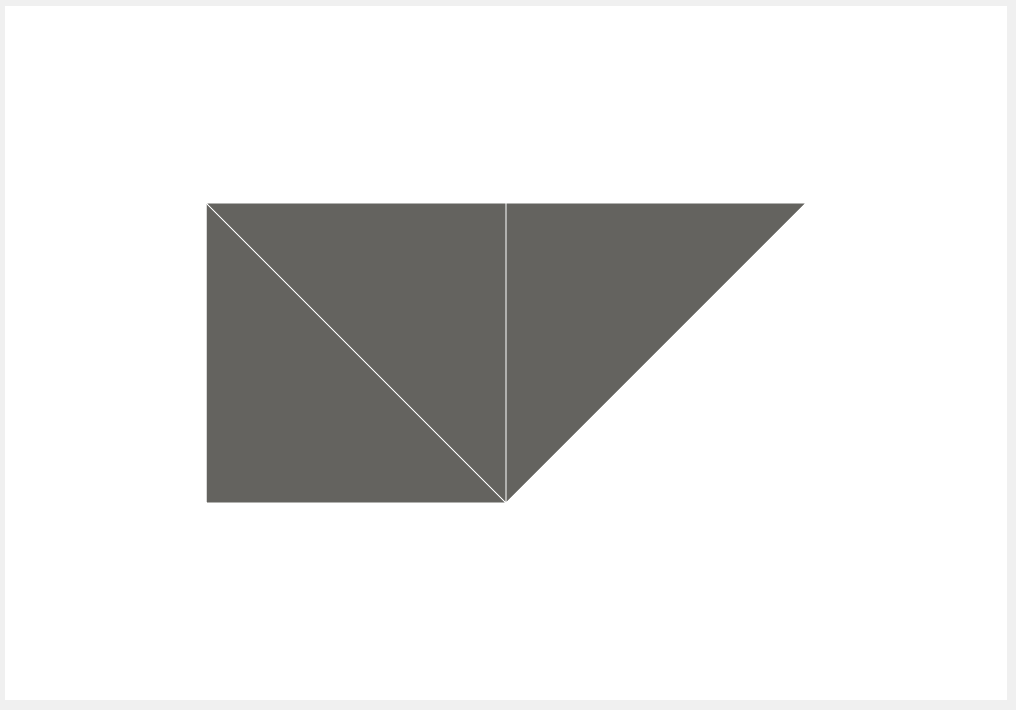

## Defining a SolutionMat object and plot
The MeshSolution object allows to make the link between data (such as FE results) and the corresponding mesh stored in a Mesh object. Thus, all the plot and post-processing methods should be available in the MeshSolution class.

The main available post-processing are the plots (such as plot_contour and plot_glyph).

Here is an example with plot_contour: a scalar field is defined by giving its values all points of the previous mesh. 

In [3]:
import numpy as np
from pyleecan.Classes.SolutionMat import SolutionMat

field = np.array([[10, 11, 12, 13, 14]])
my_solution = SolutionMat(
    label="my_field",
    type_cell="point",
    field=field,
    indice=[0, 1, 2, 3, 4],
    axis_name=["time", "indice"],
    axis_size = [1, 5],
)
MSol.solution.append(my_solution)
MSol.plot_contour()

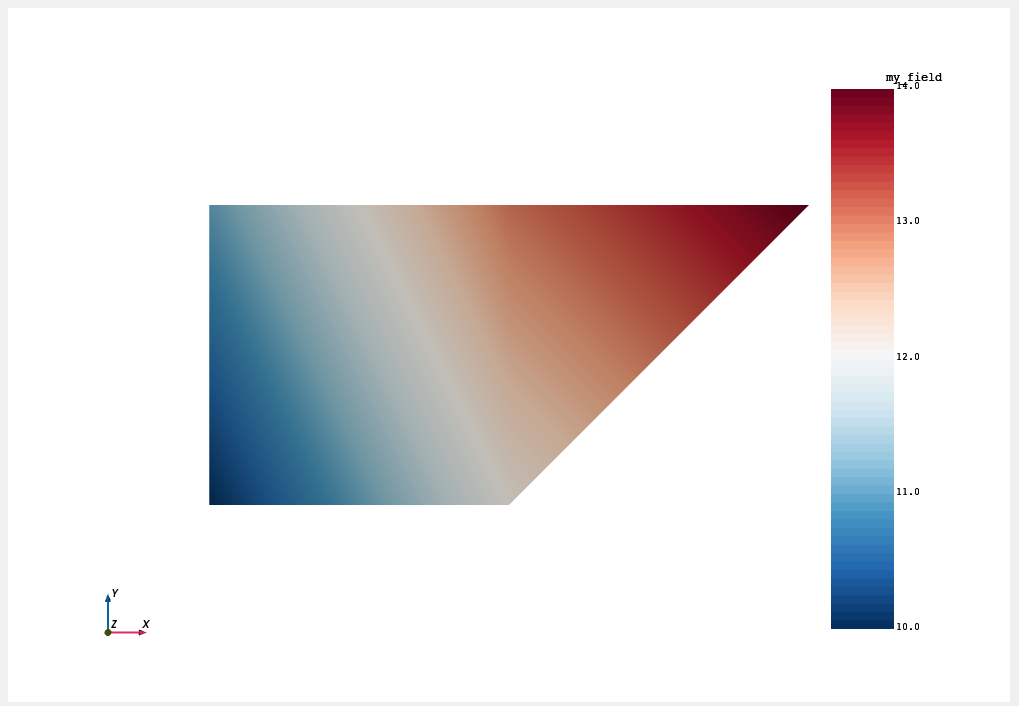

The notion of axis allows to correctly extract values as it would be with SciDataTool objects -> same way to call methods in SolutionMat/SolutionData/SolutionVector. 

Using SolutionMat, one can also defined a vector field by using an additional axis "component".

In [4]:
vector = np.ones((10,5,2))

my_vec_solution = SolutionMat(
    label="my_vector",
    type_cell="point",
    field=vector,
    indice=[0, 1, 2, 3, 4], # optional if indice are sorted and starts from 0, but field size must match with the number of corresponding point/cell.
    axis_name=["time", "indice", "component"],
    axis_size = [10, 5, 2],
)
MSol.solution.append(my_vec_solution)
MSol.plot_glyph(label="my_vector", is_point_arrow=True, factor=1/10)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In this example, a 2D field is defined on a 3D mesh. Indeed, the mesh and the field have distinct "dimension" attributes. It enables to limit the memory space when possible. 

## Import an external Mesh

At the moment, Pyleecan mainly relies on the meshio librairy to convert any type of mesh file into a .vtk which is readable by pyvista. Any contribution on this topic is welcomed. However, we have recently added a method to import .unv files. Here is an example with a 3D mesh

In [5]:
#Convert to vtk with meshio
from pyleecan.definitions import TEST_DIR
from pyleecan.Classes.ImportMeshMat import ImportMeshMat
import meshio
from os.path import join
test_obj = ImportMeshMat(
    file_path=join(TEST_DIR, join(TEST_DIR, 'Data/Mesh/mesh_test_mixte.unv')),
)
mesh = test_obj.get_data()
    
# Import in Pyleecan with MeshVTK
MS = MeshSolution(mesh=[mesh])
MS.plot_mesh()

None


<pyvistaqt.plotting.BackgroundPlotter(0x2048f6a7e20) at 0x0000020489E0CFC0>

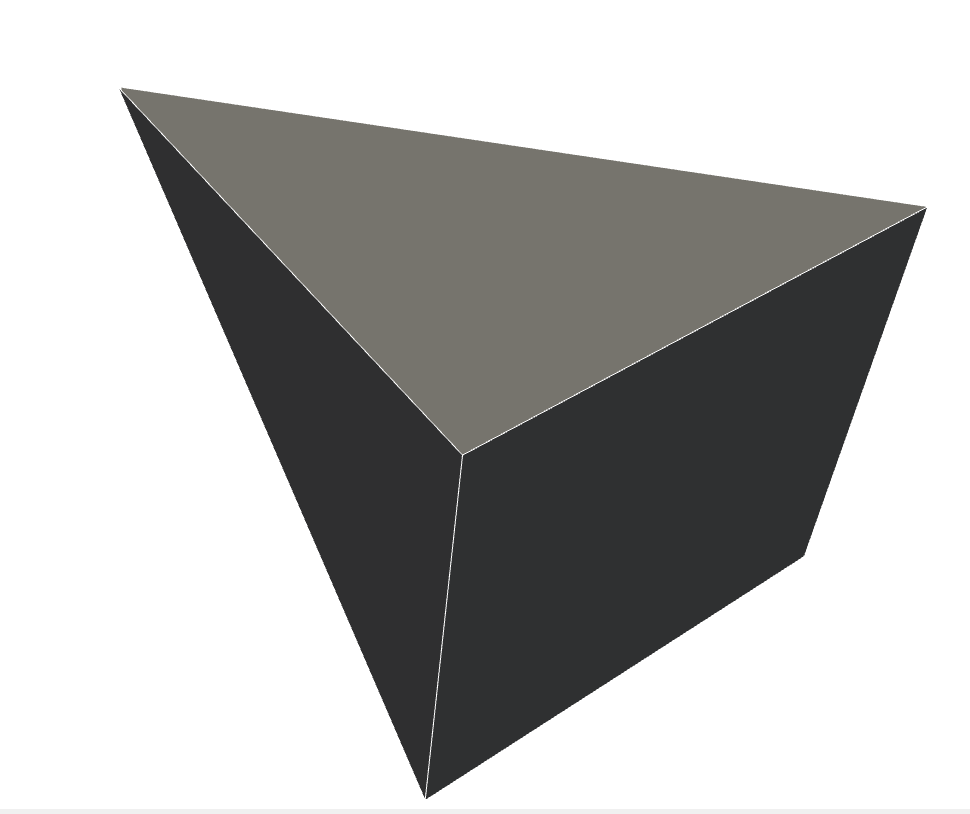

# Demo with FEMM results
The aim of this section is to show how MeshSolution object are used in Pyleecan to post-process FE results. 

d:\github\pyleecan-public\pyleecan\Methods\Machine\Machine\plot.py:189: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


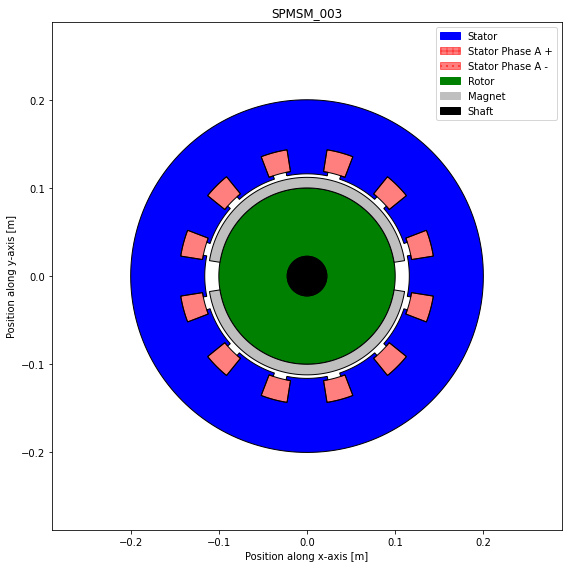

In [8]:
%matplotlib inline
# Run the FEMM simulation such as in tuto_Simulation_FEMM
import json
from multiprocessing import cpu_count
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pytest
from numpy import array, ones, pi, zeros
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.Output import Output
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.definitions import DATA_DIR
from pyleecan.Functions.load import load
from Tests import save_load_path, save_plot_path

SPMSM_003 = load(join(DATA_DIR, "Machine", "SPMSM_003.json"))
SPMSM_003.plot()
simu = Simu1(name="test_SIPMSM_003", machine=SPMSM_003)

# Definition of the enforced output of the electrical module
N0 = 3000
Is = ImportMatrixVal(
    value=array(
        [
            [6.97244193e-06, 2.25353053e02, -2.25353060e02],
            [-2.60215295e02, 1.30107654e02, 1.30107642e02],
            [-6.97244208e-06, -2.25353053e02, 2.25353060e02],
            [2.60215295e02, -1.30107654e02, -1.30107642e02],
        ]
    )
)
time = ImportGenVectLin(start=0, stop=0.015, num=4, endpoint=True)
Na_tot = 1024

simu.input = InputCurrent(
    Is=Is,
    Ir=None,  # No winding on the rotor
    OP=OPdq(N0=N0),
    time=time,
    Na_tot=Na_tot,
    angle_rotor_initial=0.5216 + pi,
)


To enable the FE results saving: is_get_mesh 

In [ ]:
# Definition of the magnetic simulation (no symmetry)
simu.mag = MagFEMM(
    type_BH_stator=1,
    type_BH_rotor=1,
    is_periodicity_a=True,
    is_get_meshsolution=True,
    nb_worker=cpu_count(),
)
out_femm = simu.run()

Now, the magnetic FEA results can be plotted. Moreover, the solution can be extracted on a specific area. By default, the field is plotted on the first dimension of every additional axis (e.g. time).

In [ ]:
out_femm.mag.meshsolution.plot_contour()

In [ ]:
out_femm.mag.meshsolution.plot_contour(label="H", group_names="stator core")

In [ ]:
out_femm.mag.meshsolution.plot_glyph(label="H", group_names="stator winding")

In [ ]:
out_femm.mag.meshsolution.plot_contour(label="B", group_names="airgap")

The algorithm is even capable of extracting the interface between two groups:

In [ ]:
out_femm.mag.meshsolution.plot_mesh(group_names=["stator core", "/", "airgap", "stator winding"])

Slices through addtional axes can be obtained using [SciDataTool](https://github.com/Eomys/SciDataTool) alike call. For example, if I want the magnetic field at the second time step:

In [ ]:
out_femm.mag.meshsolution.plot_contour(
    "time[2]",
    label="H",
    save_path=join(save_plot_path, simu.name + "_H_time2.png"),
    is_show_fig=False,
)

# Extract and post-process data

Several methods have been developed for the MeshSolution class in order to load the results regardless of the type of objects. The main method of MeshSolution is get_field. The first arguments can be written similarly to [SciDataTool](https://github.com/Eomys/SciDataTool) call. For example if I want to get the magnetic flux density at the first time step after FEMM calculations:

In [ ]:
B = out_femm.mag.meshsolution.get_field("time[0]", "indice", "component", label='B')
B.shape

Another useful feature is the groups. The groups allows to define submeshes corresponding to subpart of the machine. A new MeshSolution object can be created from the group definition:

In [ ]:
group_stator = out_femm.mag.meshsolution.get_group("stator core")


Then, the magnetic solution is filtered on the selected cells (triangular elements in this case). 

In [ ]:
B_s = group_stator.get_field("indice", "time", "component", label='B')
H_s = group_stator.get_field("indice", "time", "component", label='H')
H_s.shape

The dimension of the field has been obviously reduced to the stator number of cells. Then, operations can be performed on the solution of this group, and plotted. It is worth noting that several type of Solution objects can co-exist in the same MeshSolution object.

In [ ]:
from pyleecan.Classes.SolutionMat import SolutionMat
w_mag = np.multiply(B_s,H_s)/2

my_vec_solution = SolutionMat(
    label="w_mag",
    type_cell="triangle",
    field=w_mag,
    axis_name=["indice", "time", "component"],
    axis_size = [5715, 4, 2],
)
group_stator.solution.append(my_vec_solution)
group_stator.plot_contour(label="w_mag")

Operations can also be performed on the mesh.

In [ ]:
nodes_s = group_stator.get_mesh().get_node()
nodes_s.shape

Then, rotate the mesh

In [ ]:
th = np.pi/2
R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
nodes_s = np.dot(nodes_s, R)
group_stator.mesh[0].node.coordinate = nodes_s
group_stator.plot_mesh()

Previous plots still work !

In [ ]:
group_stator.plot_contour(label="w_mag")

Thanks for following this tutorial ! :-)